# Reproducibility study on: *Fairness without Demographics through Adversarially Reweighted Learning*
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomFrederik/fact-ai/blob/main/results.ipynb)

This notebook can reproduce all the figures and tables from our report. You can run it from top to bottom without interventions or you can use it more interactively and tweak things along the way.

You need to first run the cells in the Setup section. After that, each section can be run independently so feel free to skip.

If you simply run the notebook from top to bottom, all the results will be based your own models trained from scratch. However, if you don't want to train your own models, you can also load our final results instead and play around with those. Instructions on how to do so are in each section.

**Note:** *If you want to run code using the image dataset, you need to download that first by running `./prepare_data.sh`! If you don't want to do that, skip the cells in the "Image dataset" subsection below and either use our prepared data or train your model only on the tabular datasets.*


In [ ]:
!./prepare_data.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3881k  100 3881k    0     0  1325k      0  0:00:02  0:00:02 --:--:-- 1325k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1956k  100 1956k    0     0   828k      0  0:00:02  0:00:02 --:--:--  828k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2486k  100 2486k    0     0  2109k      0  0:00:01  0:00:01 --:--:-- 2109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1858k  100 1858k    0     0   923k      0  0:00:02  0:00:02 --:--:--  923k
Archive:  LSAC/LSAC_SAS.zip
replace LSAC/lsac.sas7bd

A final note if you're curious about the behind-the-scenes stuff: the notebook uses a lot of helper functions imported from `analysis_utils.py` to hide some of the boring implementation details. Nothing exciting happens there but if you're curious what some function does, you can look at the source code there.

The heavy lifting - all the training and evaluation - is done in the `main()` function in `main.py` (and in the modules that are imported from there). That function is very flexible: if you want to change something, first look at the `args` object we define below and see whether you can achieve your goal by changing hyperparameters there. If that's not enough, a good starting point to dive into the code is probably the `train()` function in `main.py`. It does a single training run and contains most of the training logic.

## Setup
We first need to import some modules and set up some global configuration.

In [1]:
from argparse import Namespace
import itertools
import json
import statistics
import os
from collections import defaultdict
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import main
import plot
import computational_identifiability as identifiability
import example_ARL_weights as adversary_outputs
from analysis_utils import *

Cuda available? False
Cuda available? False


All of the training commands we'll use take a `Namespace` object containing their configuration as an input. The following `args` variable will be used as the blueprint for all such configuration objects. You can leave it as it is, or read the comments to see what you might want to change.

In [2]:
default_args = Namespace(
    #############
    # These parameters don't affect the behavior, set them to maximize performance on your machine
    #############
    # batch size used during evaluation runs
    eval_batch_size=512,
    # number of workers for the Dataloader
    num_workers=4,
    
    #############
    # These are default hyperparameters that will be used throughout.
    # If you want to exactly reproduce our results/those from the paper,
    # leave them unchanged.
    #############
    # Number of units in the primary learner hidden layers
    prim_hidden=[64, 32],
    # Number of units in the adversary hidden layers.
    # Default is [], i.e. a linear adversary.
    # Only relevant for ARL.
    adv_hidden=[],
    # Inputs the adversary has access to, can contain 'X' for features,
    # 'Y' for labels and 'S' for protected group memberships
    adv_input=['X', 'Y'],
    seed=0,
    # Number of steps to pretrain the learner before the adversary.
    # Only relevant for ARL
    pretrain_steps=250,
    # maximum number of training steps, excluding pretraining (we use early stopping,
    # so actual training may be shorter)
    train_steps=10,
    # Optimizer, options are 'Adagrad' and 'Adam'
    opt='Adagrad',
    # Whether to use the Tensorflow defaults instead of the Pytorch ones.
    # (TF has different default initializations and settings for optimizers.
    # Because we want to reproduce the results the authors got using TF,
    # we use the TF defaults rather than the Pytorch ones, but you can disable
    # this behavior by setting tf_mode to False)
    tf_mode=True,
    
    #############
    # The following parameters will typically be adjusted for each run anyways.
    # Feel free to specify any defaults you want.
    #############
    # Choices are 'Adult', 'LSAC', 'COMPAS' and 'EMNIST'
    dataset='Adult',
    # Choices are 'ARL', 'DRO', 'baseline' and 'IPW'
    model='ARL',
    batch_size=256,
    prim_lr=0.1,
    # For IPW: False means using IPW(S), True means using IPW(S+Y)
    sensitive_label=False,
    # DRO hparams
    eta=0.5,
    k=2.0,
    
    #############
    # Leave the following parameters as they are unless you know what you're doing.
    # They are used by our shell scripts but not relevant in a notebook context.
    #############
    grid_search=False,
    # These only affect grid searches and don't matter otherwise
    num_cpus=1,
    num_gpus=0.25,
    # progress bar won't work in notebook
    p_bar=False,
    disable_warnings=True,
    # This directory will be used to save logs and checkpoint from your own runs.
    log_dir='training_logs',
    seed_run=False,
    seed_run_version=0,
    # Number of folds for cross validation, only used during grid search
    num_folds=5,
    version=None
)
default_args.dataset_type = 'image' if default_args.dataset == 'EMNIST' else 'tabular'
default_args.working_dir = os.getcwd()

You can also change the number of seeds that will be used to create reliable results:

In [3]:
NUM_SEEDS = 1

## The datasets
We start with a brief look at the datasets we use, so we know what we're dealing with.

### Tabular datasets
The paper tests ARL on three tabular datasets and we use the same ones.

First up is the Adult dataset:

In [4]:
adult = pd.read_csv('data/Adult/train.csv')
print(f"{len(adult)} samples")
adult.head()

32561 samples


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


The target variable here is `income`, which can be `<=50K` or `>50K`.
As with all of these tabular datasets, the protected features are race and sex, which are imbalanced in these datasets:

In [5]:
pd.crosstab(adult.sex, adult.race)

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
sex,,,,,
Female,119,346,1555,109,8642
Male,192,693,1569,162,19174


For all of the experiments, the authors binarized these protected features to `['Female', 'Other']` and `['Black', 'Other']`, so this is what we do as well (this happens automatically in `datasets.py` when we load a dataset). This means there are four protected groups throughout.

Let's look at the two other tabular datasets as well:

In [6]:
lsac = pd.read_csv('data/LSAC/train.csv')
print(f"{len(lsac)} samples")
lsac.head()

18585 samples


,zfygpa,zgpa,DOB_yr,isPartTime,sex,race,cluster_tier,family_income,lsat,ugpa,pass_bar,weighted_lsat_ugpa
0,0.14,-0.73,63.0,No,Male,White,3.0,4.0,37.0,2.5,Passed,676.315771
1,-1.48,0.00,69.0,No,Male,White,3.0,2.0,31.0,3.5,Failed_or_not_attempted,681.578933
2,0.61,-0.09,69.0,No,Male,White,4.0,2.0,34.0,3.4,Passed,718.947352
3,0.14,-0.50,66.0,No,Male,White,5.0,3.0,45.0,3.9,Passed,942.631555
4,0.99,0.94,67.0,No,Male,White,2.0,3.0,32.0,3.2,Failed_or_not_attempted,667.368406


In [7]:
pd.crosstab(lsac.sex, lsac.race)

race,Black,Other,White
sex,,,
Female,743,905,6563
Male,511,1087,8776


For the LSAC dataset, the target variable is `pass_bar`. One peculiarity compared to the other datasets is that there are fewer black male samples than black female. This means that the "minority AUC" metric for this dataset refers to the AUC over all black male samples (the minority is automatically determined so that the metric is calculated correctly).

Finally, we have the COMPAS dataset, where the target variable is `is_recid`:

In [8]:
compas = pd.read_csv('data/COMPAS/train.csv')
print(f"{len(compas)} samples")
compas.head()

5029 samples


,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age,c_charge_degree,c_charge_desc,age_cat,sex,race,is_recid
0,0,0,0,1,27,M,Opert With Susp DL 2nd Offens,25 - 45,Male,White,Yes
1,0,0,0,0,26,M,Grand Theft (Motor Vehicle),25 - 45,Male,White,No
2,0,0,0,0,22,M,Battery,Less than 25,Female,Other,No
3,0,0,0,0,50,F,Carrying Concealed Firearm,Greater than 45,Male,White,No
4,0,0,0,1,21,F,arrest case no charge,Less than 25,Male,White,No


In [9]:
pd.crosstab(compas.sex, compas.race)

race,Black,Other,White
sex,,,
Female,440,117,404
Male,2107,638,1323


### Image dataset
In addition to the tabular datasets used by the authors, we tested ARL on image data, to see how well it works on other modalities. We used a dataset based on EMNIST.

Remember, to run these cells you need to create the dataset first by running `./prepare_data.sh`.

In [10]:
from datasets import EMNISTDataset
emnist = EMNISTDataset()
print(f"{len(emnist)} samples")

61306 samples


Just like the tabular dataset, a sample from our modified EMNIST dataset contains features, a binary label, and a membership in a protected group. In contrast to the tabular data with four protected groups, there are only two for this dataset.

The features are not tabular data, but instead a grayscale image of 28x28 pixels.

In [11]:
x, y, s = emnist[0]
print(x.shape)
print(y)
print(s)

torch.Size([1, 28, 28])
tensor(1.)
tensor(0.)


The (balanced) EMNIST dataset contains 47 different classes. Below, we plot some examples of the characters:

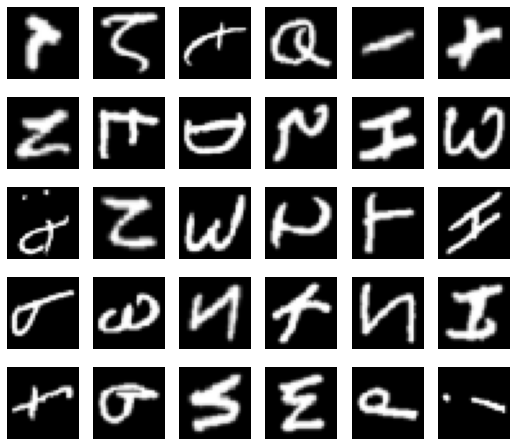

In [12]:
plt.figure(figsize=(9, 8))
for i in range(30):
    x, y, s = emnist[i]
    plt.subplot(5, 6, i + 1)
    plt.imshow(x.squeeze().numpy(), cmap='gray')
    plt.axis('off')

## Single training run
We begin by training end evaluating a single model to show how our interface works in a simple setting. You can skip this section if you want to immediately reproduce our results.


In the previous section, we created a set of default arguments for the training process. Whenever we do a training run and want to adjust any options, we copy this default config and then make changes:

In [13]:
args = Namespace(**vars(default_args))
args.model = 'ARL'
args.dataset = 'Adult'

See the previous section for a complete list of options, including explanations.

The `main` function does the following:
1. Load the dataset
2. Randomly split off 10% of the training set as a validation set
3. Train the model, using the validation set for early stopping
4. Load the best model (according to validation performance)
5. Evaluate the performance of that model on the test set

It prints out the final test performance and also saves it to disk, as well as checkpoints and tensorboard logs. Running it for a single model and dataset should take a few minutes at most.

It can also perform a grid search to find the optimal learning rate and batch size, see the notes at the end of this notebook.

In [14]:
main.main(args)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | learner   | Learner           | 8.6 K 
1 | adversary | Adversary         | 103   
2 | loss_fct  | BCEWithLogitsLoss | 0     
------------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params


creating dir ./training_logs/Adult/ARL/version_1611826212


/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: training_step returned None if it was on purpose, ignore this warning...
  warnings.warn(*args, **kwargs)


time to fit was 4.215067386627197
Results = {'min_auc': 0.884012758731842, 'macro_avg_auc': 0.9178934246301651, 'micro_avg_auc': 0.9089484214782715, 'minority_auc': 0.939019501209259, 'accuracy': 0.8557828068733215}


{'min_auc': 0.884012758731842,
 'macro_avg_auc': 0.9178934246301651,
 'micro_avg_auc': 0.9089484214782715,
 'minority_auc': 0.939019501209259,
 'accuracy': 0.8557828068733215}

If you want to observe the runs using Tensorboard, you can run `tensorboard --logdir training_logs` in your command line. You can also inspect our final runs using the `final_logs` logdir. The runs in the next section will be saved to `complete_run_logs` so they are clearly separated from individual experimental runs like the one we just did.

## Runs for all models and datasets
To recreate the tables from our report, we need to train every model on each of the datasets. We also need to do several runs with different seeds for each combination. This may take a bit longer (on the order of a few hours), so you can also skip directly to the next section and create the tables and figures based on our results.

First, we need to choose which combinations of datasets and models we want to train. The defaults below will reproduce all the results from our report but feel free to remove some if you only want to test specific combinations.

The desired runs are stored in `dataset_model_list`, which contains tuples of the form `(dataset, model)`, such as `('Adult', 'ARL')`. We use `itertools.product` for convenience to create all possible combinations but you can create/modify this list in any way you want (there is no reason why every method has to be combined with every dataset).

**Note:** If you want to add other methods than the baseline and ARL for the EMNIST dataset, you will need to speficy your own hyperparameters for those (see below). For computational reasons, we only used those two models for EMNIST, so we don't know what good hyperparameters are for the other methods and don't provide any.

In [4]:
dataset_model_list = []
# For the tabular datasets, we use all the methods
# Note that here, we allow IPW(S) and IPW(S+Y) as model names,
# even though the documentation in the Setup section only listed
# IPW as an option. `run_model`, which we'll use below, handles this
# behind the scenes and sets `sensitive_label` accordingly.
models = ['baseline', 'DRO', 'ARL', 'IPW(S)', 'IPW(S+Y)']
datasets = ['Adult', 'LSAC', 'COMPAS']
dataset_model_list += list(itertools.product(datasets, models))

# The runs for EMNIST take longer, so we only train the baseline model and ARL by default
# but you can add more methods
models = ['baseline', 'ARL']
datasets = ['EMNIST']
dataset_model_list += list(itertools.product(datasets, models))
print('Dataset/model combinations that will be trained:')
print('\n'.join(map(str, dataset_model_list)))

Dataset/model combinations that will be trained:
('Adult', 'baseline')
('Adult', 'DRO')
('Adult', 'ARL')
('Adult', 'IPW(S)')
('Adult', 'IPW(S+Y)')
('LSAC', 'baseline')
('LSAC', 'DRO')
('LSAC', 'ARL')
('LSAC', 'IPW(S)')
('LSAC', 'IPW(S+Y)')
('COMPAS', 'baseline')
('COMPAS', 'DRO')
('COMPAS', 'ARL')
('COMPAS', 'IPW(S)')
('COMPAS', 'IPW(S+Y)')
('EMNIST', 'baseline')
('EMNIST', 'ARL')


Now we load the optimal hyperparameters that we determined using grid search. If you want to do your own grid search, take a look at the notes at the end of this notebook first.

In [5]:
with open('optimal_hparams.json') as f:
    optimal_hparams = json.load(f)

The hyperparameter settings are simply a dictionary:

In [6]:
print(json.dumps(optimal_hparams, indent=4))

{
    "Adult": {
        "baseline": {
            "batch_size": 512,
            "prim_lr": 2
        },
        "DRO": {
            "batch_size": 128,
            "prim_lr": 1,
            "eta": 0.5
        },
        "ARL": {
            "batch_size": 128,
            "prim_lr": 0.1
        },
        "IPW(S)": {
            "batch_size": 128,
            "prim_lr": 0.01
        },
        "IPW(S+Y)": {
            "batch_size": 256,
            "prim_lr": 0.1
        }
    },
    "LSAC": {
        "baseline": {
            "batch_size": 64,
            "prim_lr": 0.1
        },
        "DRO": {
            "batch_size": 128,
            "prim_lr": 1,
            "eta": 0.6
        },
        "ARL": {
            "batch_size": 64,
            "prim_lr": 0.1
        },
        "IPW(S)": {
            "batch_size": 256,
            "prim_lr": 0.1
        },
        "IPW(S+Y)": {
            "batch_size": 64,
            "prim_lr": 0.1
        }
    },
    "COMPAS": {
        "baseli

If you want to use your own hyperparameters instead, you can therefore just change or overwrite the `optimal_hparams` variable. You are also not limited to setting learning rate and batch size; you can set any of the `args` attributes individually for each model/dataset combination. Any values that are not set use the defaults we specified above.

Now we do runs with 10 different seeds for all the dataset/model combinations specified above. You can change the number of seeds (and/or use different seeds than 0, ..., 9).

In [7]:
all_dicts = []

for seed in range(NUM_SEEDS):
    all_dicts.append(run_models(seed, default_args, optimal_hparams, dataset_model_list))

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Sequential        | 8.6 K 
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params


creating dir ./complete_run_logs/Adult/baseline/version_1611827187
time to fit was 0.754025936126709
Results = {'min_auc': 0.5651807188987732, 'macro_avg_auc': 0.606637105345726, 'micro_avg_auc': 0.6138712167739868, 'minority_auc': 0.590583324432373, 'accuracy': 0.7637737393379211}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Sequential        | 8.6 K 
1 | loss_fct | DRO_loss          | 0     
2 | bce      | BCEWithLogitsLoss | 0     
-----------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params


creating dir ./complete_run_logs/Adult/DRO/version_1611827193
time to fit was 3.1597962379455566
Results = {'min_auc': 0.8816644549369812, 'macro_avg_auc': 0.9176488071680069, 'micro_avg_auc': 0.9071617722511292, 'minority_auc': 0.9442769885063171, 'accuracy': 0.8560899496078491}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | learner   | Learner           | 8.6 K 
1 | adversary | Adversary         | 103   
2 | loss_fct  | BCEWithLogitsLoss | 0     
------------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params


creating dir ./complete_run_logs/Adult/ARL/version_1611827201


/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: training_step returned None if it was on purpose, ignore this warning...
  warnings.warn(*args, **kwargs)


time to fit was 3.4721639156341553
Results = {'min_auc': 0.8838906288146973, 'macro_avg_auc': 0.917955294251442, 'micro_avg_auc': 0.909183144569397, 'minority_auc': 0.9403924942016602, 'accuracy': 0.8571954965591431}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | learner  | Learner           | 8.6 K 
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params


creating dir ./complete_run_logs/Adult/IPW(S)/version_1611827211
time to fit was 0.8995790481567383
Results = {'min_auc': 0.7730317115783691, 'macro_avg_auc': 0.8252956122159958, 'micro_avg_auc': 0.8001481294631958, 'minority_auc': 0.881220281124115, 'accuracy': 0.7637737393379211}
creating dir ./complete_run_logs/Adult/IPW(S+Y)/version_1611827219


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | learner  | Learner           | 8.6 K 
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params


time to fit was 0.7650537490844727
Results = {'min_auc': 0.8634945154190063, 'macro_avg_auc': 0.9014457613229752, 'micro_avg_auc': 0.8909643888473511, 'minority_auc': 0.9312839508056641, 'accuracy': 0.7409864068031311}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Sequential        | 2.8 K 
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params


creating dir ./complete_run_logs/LSAC/baseline/version_1611827227
time to fit was 0.48876023292541504
Results = {'min_auc': 0.6743922233581543, 'macro_avg_auc': 0.7032131254673004, 'micro_avg_auc': 0.7035446763038635, 'minority_auc': 0.7246260643005371, 'accuracy': 0.810695469379425}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Sequential        | 2.8 K 
1 | loss_fct | DRO_loss          | 0     
2 | bce      | BCEWithLogitsLoss | 0     
-----------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params


creating dir ./complete_run_logs/LSAC/DRO/version_1611827231
time to fit was 2.5728352069854736
Results = {'min_auc': 0.7476955652236938, 'macro_avg_auc': 0.7759598940610886, 'micro_avg_auc': 0.7716999650001526, 'minority_auc': 0.781606137752533, 'accuracy': 0.8276425004005432}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | learner   | Learner           | 2.8 K 
1 | adversary | Adversary         | 12    
2 | loss_fct  | BCEWithLogitsLoss | 0     
------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params


creating dir ./complete_run_logs/LSAC/ARL/version_1611827237
time to fit was 2.1775453090667725
Results = {'min_auc': 0.7342615723609924, 'macro_avg_auc': 0.7572819888591766, 'micro_avg_auc': 0.7592031359672546, 'minority_auc': 0.7700321078300476, 'accuracy': 0.8337936401367188}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | learner  | Learner           | 2.8 K 
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params


creating dir ./complete_run_logs/LSAC/IPW(S)/version_1611827243
time to fit was 0.5630457401275635
Results = {'min_auc': 0.6911125183105469, 'macro_avg_auc': 0.7342090755701065, 'micro_avg_auc': 0.7176227569580078, 'minority_auc': 0.7718126773834229, 'accuracy': 0.8179764151573181}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | learner  | Learner           | 2.8 K 
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params


creating dir ./complete_run_logs/LSAC/IPW(S+Y)/version_1611827246
time to fit was 0.4619324207305908
Results = {'min_auc': 0.7072097659111023, 'macro_avg_auc': 0.7364931106567383, 'micro_avg_auc': 0.7294859886169434, 'minority_auc': 0.7556089758872986, 'accuracy': 0.808184802532196}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Sequential        | 30.8 K
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params


creating dir ./complete_run_logs/COMPAS/baseline/version_1611827251
time to fit was 0.35866641998291016
Results = {'min_auc': 0.6795536279678345, 'macro_avg_auc': 0.6981346607208252, 'micro_avg_auc': 0.7062586545944214, 'minority_auc': 0.7230275869369507, 'accuracy': 0.6400741934776306}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Sequential        | 30.8 K
1 | loss_fct | DRO_loss          | 0     
2 | bce      | BCEWithLogitsLoss | 0     
-----------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params


creating dir ./complete_run_logs/COMPAS/DRO/version_1611827252
time to fit was 6.210033893585205
Results = {'min_auc': 0.7005159258842468, 'macro_avg_auc': 0.7319859713315964, 'micro_avg_auc': 0.735049843788147, 'minority_auc': 0.7512327432632446, 'accuracy': 0.6679035425186157}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | learner   | Learner           | 30.8 K
1 | adversary | Adversary         | 449   
2 | loss_fct  | BCEWithLogitsLoss | 0     
------------------------------------------------
31.2 K    Trainable params
0         Non-trainable params
31.2 K    Total params


creating dir ./complete_run_logs/COMPAS/ARL/version_1611827259
time to fit was 6.359504699707031
Results = {'min_auc': 0.6971350908279419, 'macro_avg_auc': 0.7331880480051041, 'micro_avg_auc': 0.7348774075508118, 'minority_auc': 0.7487672567367554, 'accuracy': 0.6665120720863342}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | learner  | Learner           | 30.8 K
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params


creating dir ./complete_run_logs/COMPAS/IPW(S)/version_1611827267
time to fit was 0.47031116485595703
Results = {'min_auc': 0.6864989399909973, 'macro_avg_auc': 0.7222408652305603, 'micro_avg_auc': 0.7219926118850708, 'minority_auc': 0.749950647354126, 'accuracy': 0.6706864833831787}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | learner  | Learner           | 30.8 K
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params


creating dir ./complete_run_logs/COMPAS/IPW(S+Y)/version_1611827269
time to fit was 0.9401190280914307
Results = {'min_auc': 0.6960335969924927, 'macro_avg_auc': 0.7214667946100235, 'micro_avg_auc': 0.7265592217445374, 'minority_auc': 0.7443293929100037, 'accuracy': 0.6651206016540527}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | cnn      | Sequential        | 640   
1 | net      | Sequential        | 694 K 
2 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
695 K     Trainable params
0         Non-trainable params
695 K     Total params


creating dir ./complete_run_logs/EMNIST/baseline/version_1611827271
time to fit was 8.80854845046997
Results = {'min_auc': 0.5086535811424255, 'macro_avg_auc': 0.6270560324192047, 'micro_avg_auc': 0.7237970232963562, 'minority_auc': 0.7454584836959839, 'accuracy': 0.6329113841056824}


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | learner   | CNN_Learner       | 695 K 
1 | adversary | CNN_Adversary     | 11.5 K
2 | loss_fct  | BCEWithLogitsLoss | 0     
------------------------------------------------
706 K     Trainable params
0         Non-trainable params
706 K     Total params


creating dir ./complete_run_logs/EMNIST/ARL/version_1611827291
time to fit was 149.1567988395691
Results = {'min_auc': 0.6261046528816223, 'macro_avg_auc': 0.7487154006958008, 'micro_avg_auc': 0.8523166179656982, 'minority_auc': 0.8713261485099792, 'accuracy': 0.775291919708252}


Finally, we calculate the means and standard deviations over those runs:

In [14]:
our_results = result_list_to_dict(all_dicts, dataset_model_list, MAIN_RESULTS_KEYS)

StatisticsError: variance requires at least two data points

## Creating the performance tables

If you didn't run train your own models in the previous section, then uncomment and run the following cell, in order to load our results:

In [15]:
# You can adjust here which models and datasets you want to run
#models = ['baseline', 'DRO', 'ARL', 'IPW(S)', 'IPW(S+Y)']
#datasets = ['Adult', 'LSAC', 'COMPAS', 'EMNIST']

#our_results = load_result_dict('final_logs', datasets, models, get_our_path)

Didn't find results for EMNIST, baseline, skipping
Didn't find results for EMNIST, DRO, skipping
Didn't find results for EMNIST, ARL, skipping
Didn't find results for EMNIST, IPW(S), skipping
Didn't find results for EMNIST, IPW(S+Y), skipping


Since we only ran the baseline and ARL model on EMNIST, some results will be missing and won't be loaded. The analysis below will still work, it doesn't require the result dictionary to contain all dataset/model combinations.

For each dataset/model combination and each metric, the results dict contains the mean and standard deviation across the 10 runs with different seeds:

In [16]:
our_results

{('Adult',
  'baseline'): {'min_auc': {'mean': 0.8841554284095764,
   'std': 0.001854611751477643}, 'macro_avg_auc': {'mean': 0.9192625850439071,
   'std': 0.0011282166339539464}, 'micro_avg_auc': {'mean': 0.9093350052833558,
   'std': 0.0015697947803360107}, 'minority_auc': {'mean': 0.9439521610736847,
   'std': 0.00402528608154091}, 'accuracy': {'mean': 0.8498372375965119,
   'std': 0.007023698725317251}},
 ('Adult',
  'DRO'): {'min_auc': {'mean': 0.885297292470932,
   'std': 0.0006518614005294807}, 'macro_avg_auc': {'mean': 0.918700386583805,
   'std': 0.001815989101837644}, 'micro_avg_auc': {'mean': 0.9101847589015961,
   'std': 0.0007322508613241217}, 'minority_auc': {'mean': 0.9414238631725311,
   'std': 0.0059271811311176065}, 'accuracy': {'mean': 0.8574227571487427,
   'std': 0.0015485177592630156}},
 ('Adult',
  'ARL'): {'min_auc': {'mean': 0.8839888334274292,
   'std': 0.0009290685557899277}, 'macro_avg_auc': {'mean': 0.9177511766552925,
   'std': 0.0007697829337825584}, 'mic

We also provide helper tools to pretty print these results as Markdown tables. The `MAIN_RESULTS_KEYS` and `MAIN_RESULTS_HEADERS` are simple constants imported from `analysis_utils.py` to create those tables.

In [17]:
bold_dict = is_max(our_results, MAIN_RESULTS_KEYS)
table = create_table(our_results, MAIN_RESULTS_KEYS, bold_dict, create_markdown_line_with_std)
display(Markdown(MAIN_RESULTS_HEADER + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|
| Adult| baseline | 0.9093 +- 0.0016 | 0.9193 +- 0.0011 | 0.8842 +- 0.0019 | 0.9440 +- 0.0040 | 0.8498 +- 0.0070
| Adult| DRO | 0.9102 +- 0.0007 | 0.9187 +- 0.0018 | 0.8853 +- 0.0007 | 0.9414 +- 0.0059 | **0.8574 +- 0.0015**
| Adult| ARL | 0.9090 +- 0.0007 | 0.9178 +- 0.0008 | 0.8840 +- 0.0009 | 0.9393 +- 0.0031 | 0.8504 +- 0.0028
| Adult| IPW(S) | 0.9085 +- 0.0004 | 0.9179 +- 0.0007 | 0.8826 +- 0.0005 | 0.9434 +- 0.0018 | 0.8557 +- 0.0010
| Adult| IPW(S+Y) | **0.9110 +- 0.0009** | **0.9209 +- 0.0020** | **0.8859 +- 0.0010** | **0.9465 +- 0.0047** | 0.7428 +- 0.0160
| LSAC| baseline | 0.8309 +- 0.0061 | 0.8263 +- 0.0063 | 0.8096 +- 0.0073 | 0.8371 +- 0.0087 | **0.8604 +- 0.0047**
| LSAC| DRO | 0.8242 +- 0.0051 | 0.8217 +- 0.0053 | 0.8024 +- 0.0055 | 0.8361 +- 0.0088 | 0.8570 +- 0.0057
| LSAC| ARL | 0.8122 +- 0.0063 | 0.8063 +- 0.0091 | 0.7870 +- 0.0066 | 0.8264 +- 0.0199 | 0.7501 +- 0.0290
| LSAC| IPW(S) | 0.8147 +- 0.0066 | 0.8088 +- 0.0056 | 0.7933 +- 0.0089 | 0.8162 +- 0.0090 | 0.8483 +- 0.0033
| LSAC| IPW(S+Y) | **0.8371 +- 0.0038** | **0.8302 +- 0.0030** | **0.8150 +- 0.0054** | **0.8374 +- 0.0072** | 0.8352 +- 0.0108
| COMPAS| baseline | 0.7357 +- 0.0025 | 0.7340 +- 0.0027 | 0.6995 +- 0.0029 | 0.7475 +- 0.0024 | 0.6735 +- 0.0057
| COMPAS| DRO | 0.7361 +- 0.0030 | 0.7347 +- 0.0032 | 0.6997 +- 0.0035 | **0.7533 +- 0.0044** | 0.6688 +- 0.0071
| COMPAS| ARL | **0.7364 +- 0.0026** | **0.7347 +- 0.0032** | **0.7008 +- 0.0023** | 0.7481 +- 0.0080 | **0.6756 +- 0.0091**
| COMPAS| IPW(S) | 0.7300 +- 0.0040 | 0.7294 +- 0.0058 | 0.6914 +- 0.0024 | 0.7399 +- 0.0124 | 0.6661 +- 0.0159
| COMPAS| IPW(S+Y) | 0.7362 +- 0.0029 | 0.7346 +- 0.0031 | 0.6998 +- 0.0029 | 0.7526 +- 0.0043 | 0.6733 +- 0.0096


### Main results
First, we reproduce the tables comparing ARL against DRO and the baseline, and against IPW. We already had a table with all the results above but in the paper, the authors split this into two separate comparisons and we follow them for the report. This only changes which fields are bolded as the best entry.

In [18]:
# restrict the models we want to compare
models = ['baseline', 'DRO', 'ARL']
datasets = ['Adult', 'LSAC', 'COMPAS']
results = {(dataset, model): v for (dataset, model), v in our_results.items()
          if model in models and dataset in datasets}
# calculate maxima
bold_dict = is_max(results, MAIN_RESULTS_KEYS)

table = create_table(results, MAIN_RESULTS_KEYS, bold_dict, create_markdown_line_with_std)
display(Markdown(MAIN_RESULTS_HEADER + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|
| Adult| baseline | 0.9093 +- 0.0016 | **0.9193 +- 0.0011** | 0.8842 +- 0.0019 | **0.9440 +- 0.0040** | 0.8498 +- 0.0070
| Adult| DRO | **0.9102 +- 0.0007** | 0.9187 +- 0.0018 | **0.8853 +- 0.0007** | 0.9414 +- 0.0059 | **0.8574 +- 0.0015**
| Adult| ARL | 0.9090 +- 0.0007 | 0.9178 +- 0.0008 | 0.8840 +- 0.0009 | 0.9393 +- 0.0031 | 0.8504 +- 0.0028
| LSAC| baseline | **0.8309 +- 0.0061** | **0.8263 +- 0.0063** | **0.8096 +- 0.0073** | **0.8371 +- 0.0087** | **0.8604 +- 0.0047**
| LSAC| DRO | 0.8242 +- 0.0051 | 0.8217 +- 0.0053 | 0.8024 +- 0.0055 | 0.8361 +- 0.0088 | 0.8570 +- 0.0057
| LSAC| ARL | 0.8122 +- 0.0063 | 0.8063 +- 0.0091 | 0.7870 +- 0.0066 | 0.8264 +- 0.0199 | 0.7501 +- 0.0290
| COMPAS| baseline | 0.7357 +- 0.0025 | 0.7340 +- 0.0027 | 0.6995 +- 0.0029 | 0.7475 +- 0.0024 | 0.6735 +- 0.0057
| COMPAS| DRO | 0.7361 +- 0.0030 | 0.7347 +- 0.0032 | 0.6997 +- 0.0035 | **0.7533 +- 0.0044** | 0.6688 +- 0.0071
| COMPAS| ARL | **0.7364 +- 0.0026** | **0.7347 +- 0.0032** | **0.7008 +- 0.0023** | 0.7481 +- 0.0080 | **0.6756 +- 0.0091**


The tables in our report were generated similarly, just using LaTeX:

In [20]:
print(create_table(results, MAIN_RESULTS_KEYS, bold_dict, create_latex_line_with_std))

Adult & baseline & 0.9093 $\pm$ 0.0016 & \textbf{0.9193} $\pm$ \textbf{0.0011} & 0.8842 $\pm$ 0.0019 & \textbf{0.9440} $\pm$ \textbf{0.0040} & 0.8498 $\pm$ 0.0070\\
Adult & DRO & \textbf{0.9102} $\pm$ \textbf{0.0007} & 0.9187 $\pm$ 0.0018 & \textbf{0.8853} $\pm$ \textbf{0.0007} & 0.9414 $\pm$ 0.0059 & \textbf{0.8574} $\pm$ \textbf{0.0015}\\
Adult & ARL & 0.9090 $\pm$ 0.0007 & 0.9178 $\pm$ 0.0008 & 0.8840 $\pm$ 0.0009 & 0.9393 $\pm$ 0.0031 & 0.8504 $\pm$ 0.0028\\
LSAC & baseline & \textbf{0.8309} $\pm$ \textbf{0.0061} & \textbf{0.8263} $\pm$ \textbf{0.0063} & \textbf{0.8096} $\pm$ \textbf{0.0073} & \textbf{0.8371} $\pm$ \textbf{0.0087} & \textbf{0.8604} $\pm$ \textbf{0.0047}\\
LSAC & DRO & 0.8242 $\pm$ 0.0051 & 0.8217 $\pm$ 0.0053 & 0.8024 $\pm$ 0.0055 & 0.8361 $\pm$ 0.0088 & 0.8570 $\pm$ 0.0057\\
LSAC & ARL & 0.8122 $\pm$ 0.0063 & 0.8063 $\pm$ 0.0091 & 0.7870 $\pm$ 0.0066 & 0.8264 $\pm$ 0.0199 & 0.7501 $\pm$ 0.0290\\
COMPAS & baseline & 0.7357 $\pm$ 0.0025 & 0.7340 $\pm$ 0.0027 & 0.699

Now we repeat the same thing for a comparison to IPW:

In [21]:
models = ['ARL', 'IPW(S)', 'IPW(S+Y)']
datasets = ['Adult', 'LSAC', 'COMPAS']
results = {(dataset, model): v for (dataset, model), v in our_results.items()
          if model in models and dataset in datasets}
bold_dict = is_max(results, MAIN_RESULTS_KEYS)

table = create_table(results, MAIN_RESULTS_KEYS, bold_dict, create_markdown_line_with_std)
display(Markdown(MAIN_RESULTS_HEADER + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|
| Adult| ARL | 0.9090 +- 0.0007 | 0.9178 +- 0.0008 | 0.8840 +- 0.0009 | 0.9393 +- 0.0031 | 0.8504 +- 0.0028
| Adult| IPW(S) | 0.9085 +- 0.0004 | 0.9179 +- 0.0007 | 0.8826 +- 0.0005 | 0.9434 +- 0.0018 | **0.8557 +- 0.0010**
| Adult| IPW(S+Y) | **0.9110 +- 0.0009** | **0.9209 +- 0.0020** | **0.8859 +- 0.0010** | **0.9465 +- 0.0047** | 0.7428 +- 0.0160
| LSAC| ARL | 0.8122 +- 0.0063 | 0.8063 +- 0.0091 | 0.7870 +- 0.0066 | 0.8264 +- 0.0199 | 0.7501 +- 0.0290
| LSAC| IPW(S) | 0.8147 +- 0.0066 | 0.8088 +- 0.0056 | 0.7933 +- 0.0089 | 0.8162 +- 0.0090 | **0.8483 +- 0.0033**
| LSAC| IPW(S+Y) | **0.8371 +- 0.0038** | **0.8302 +- 0.0030** | **0.8150 +- 0.0054** | **0.8374 +- 0.0072** | 0.8352 +- 0.0108
| COMPAS| ARL | **0.7364 +- 0.0026** | **0.7347 +- 0.0032** | **0.7008 +- 0.0023** | 0.7481 +- 0.0080 | **0.6756 +- 0.0091**
| COMPAS| IPW(S) | 0.7300 +- 0.0040 | 0.7294 +- 0.0058 | 0.6914 +- 0.0024 | 0.7399 +- 0.0124 | 0.6661 +- 0.0159
| COMPAS| IPW(S+Y) | 0.7362 +- 0.0029 | 0.7346 +- 0.0031 | 0.6998 +- 0.0029 | **0.7526 +- 0.0043** | 0.6733 +- 0.0096


In [22]:
print(create_table(results, MAIN_RESULTS_KEYS, bold_dict, create_latex_line_with_std))

Adult & ARL & 0.9090 $\pm$ 0.0007 & 0.9178 $\pm$ 0.0008 & 0.8840 $\pm$ 0.0009 & 0.9393 $\pm$ 0.0031 & 0.8504 $\pm$ 0.0028\\
Adult & IPW(S) & 0.9085 $\pm$ 0.0004 & 0.9179 $\pm$ 0.0007 & 0.8826 $\pm$ 0.0005 & 0.9434 $\pm$ 0.0018 & \textbf{0.8557} $\pm$ \textbf{0.0010}\\
Adult & IPW(S+Y) & \textbf{0.9110} $\pm$ \textbf{0.0009} & \textbf{0.9209} $\pm$ \textbf{0.0020} & \textbf{0.8859} $\pm$ \textbf{0.0010} & \textbf{0.9465} $\pm$ \textbf{0.0047} & 0.7428 $\pm$ 0.0160\\
LSAC & ARL & 0.8122 $\pm$ 0.0063 & 0.8063 $\pm$ 0.0091 & 0.7870 $\pm$ 0.0066 & 0.8264 $\pm$ 0.0199 & 0.7501 $\pm$ 0.0290\\
LSAC & IPW(S) & 0.8147 $\pm$ 0.0066 & 0.8088 $\pm$ 0.0056 & 0.7933 $\pm$ 0.0089 & 0.8162 $\pm$ 0.0090 & \textbf{0.8483} $\pm$ \textbf{0.0033}\\
LSAC & IPW(S+Y) & \textbf{0.8371} $\pm$ \textbf{0.0038} & \textbf{0.8302} $\pm$ \textbf{0.0030} & \textbf{0.8150} $\pm$ \textbf{0.0054} & \textbf{0.8374} $\pm$ \textbf{0.0072} & 0.8352 $\pm$ 0.0108\\
COMPAS & ARL & \textbf{0.7364} $\pm$ \textbf{0.0026} & \textbf{

### Image results

In [25]:
models = ['baseline', 'ARL']
datasets = ['EMNIST']
results = {(dataset, model): v for (dataset, model), v in our_results.items()
          if model in models and dataset in datasets}
bold_dict = is_max(results, MAIN_RESULTS_KEYS)

table = create_table(results, MAIN_RESULTS_KEYS, bold_dict, create_markdown_line_with_std)
display(Markdown(MAIN_RESULTS_HEADER + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|Accuracy|
|---|---|---|---|---|---|---|


In [26]:
print(create_table(results, MAIN_RESULTS_KEYS, bold_dict, create_latex_line_with_std))

### Comparison to results from the paper
Next, we compare our results to those from the paper we're reproducing. Since that paper doesn't report accuracy values, we don't include those in the comparison.

In [27]:
models = ['baseline', 'DRO', 'ARL']
our_results = load_result_dict('final_logs', datasets, models, get_our_path)
for k in our_results:
    del our_results[k]["accuracy"]

Didn't find results for EMNIST, baseline, skipping
Didn't find results for EMNIST, DRO, skipping
Didn't find results for EMNIST, ARL, skipping


Next, we calculate the differences between our and their results (`absolute_errors`) and the standard error of those differences (`total_stds`). From those, we can calculate relative errors (`relative_errors`) that immediately show how significant the deviations are. We use some helper tools that we imported above to add, subtract, etc. dictionaries key-wise.

In [28]:
our_means = {k1: {k2: v2["mean"] for k2, v2 in v1.items()} for k1, v1 in our_results.items()}
our_stds = {k1: {k2: v2["std"] for k2, v2 in v1.items()} for k1, v1 in our_results.items()}

# if you want to compare to some other results instead, for example ones that you got using
# different hparams, you can load from other json files here instead
# and don't need to change anything else
models = ['baseline', 'DRO', 'ARL']
their_results = load_result_dict('paper_results', datasets, models, get_their_path)

their_means = {k1: {k2: v2["mean"] for k2, v2 in v1.items()} for k1, v1 in their_results.items()}
their_stds = {k1: {k2: v2["std"] for k2, v2 in v1.items()} for k1, v1 in their_results.items()}

absolute_errors = subtract(our_means, their_means)
total_stds = valmap(add(square(our_stds), square(their_stds)), math.sqrt)
relative_errors = div(absolute_errors, total_stds)

Didn't find results for EMNIST, baseline, skipping
Didn't find results for EMNIST, DRO, skipping
Didn't find results for EMNIST, ARL, skipping


We can again print the results as a Markdown table. `bold_dict` determines which fields of the table will be bolded. In this case, we bold all those relative errors that are at least two standard deviations.

In [29]:
bold_dict = valmap(relative_errors, lambda x: abs(x) >= 2)

table = create_table(relative_errors, DEVIATION_KEYS, bold_dict, create_markdown_line_scalar)
display(Markdown(DEVIATION_HEADER + table))


|Dataset|Method|Micro-avg AUC|Macro-avg AUC|Min AUC|Minority AUC|
|---|---|---|---|---|---|


And again in LaTeX for the report:

In [31]:
print(create_table(our_results, DEVIATION_KEYS, bold_dict, create_latex_line_with_std))

## Plots of training runs
In this section, we plot the development of various metrics during training. The data comes from the tensorboard logs, we simply aggregate the right runs and then average over seeds, calculate standard deviations, and show everything in one plot.

Below, you can adjust the dataset for which you want to get plots, as well as the metrics that are plotted. There will be one separate plot for each metric.

By default, the plots are based on your own runs from above. You can also load data from our own final runs instead.

In [32]:
plot_args = Namespace(
    # If you want to load our results instead of your own (necessary if
    # you didn't do the complete run of all models), then use 'final_logs'
    log_dir='complete_run_logs',
    #log_dir='final_logs',
    
    # split for which to plot the data. Other options are 'training' and 'test',
    # but by default those are not calculated during training for performance reasons and therefore
    # only available if you add Loggers for them in main.py
    split='validation',
    
    # you can change the dataset to 'Adult' or 'COMPAS' here
    dataset='LSAC'
)

# remove metrics that you don't want to plot
metrics = ['min_auc', 'macro_avg_auc', 'micro_avg_auc', 'minority_auc', 'accuracy']

Now we plot the results for each of the chosen metrics. The plotting script works as follows: it recursively walks the directory containing the training logs for the chosen dataset and each model and aggregates all the tensorboard logs it finds. Then it calculates the average and standard deviation over those logs and plots them.

This means you need to be careful that the `log_dir` specified in the cell above only contains the runs you want to include for the plot. If you didn't change any of the log paths, this should be the case.

Since plotting the results for all methods in one plot is a bit confusing, we again split them into a baseline vs DRO vs ARL and a ARL vs IPW comparison. You can easily adjust this using the `plot_args.models` attribute.

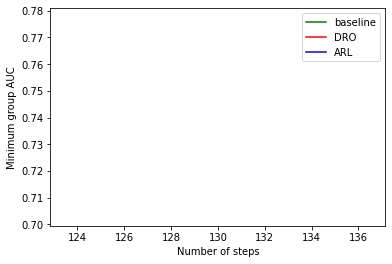

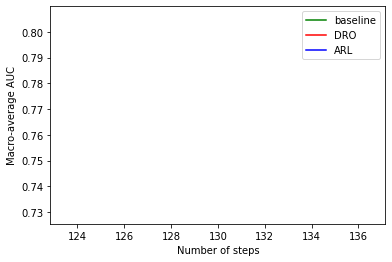

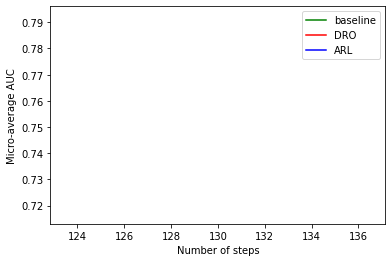

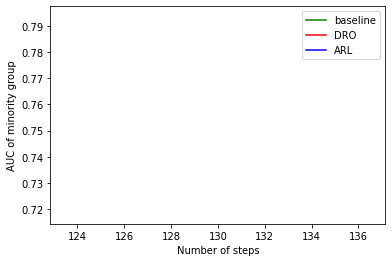

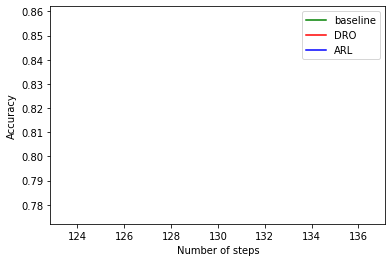

In [33]:
plot_args.models = ['baseline', 'DRO', 'ARL']
for metric in metrics:
    plot_args.metric = metric
    plot.main(plot_args)
    plt.show()

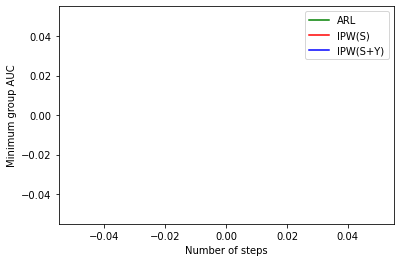

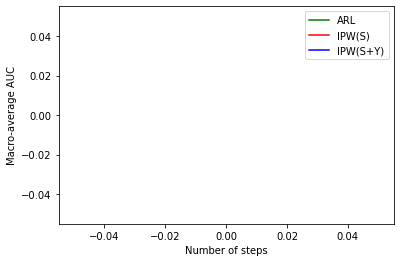

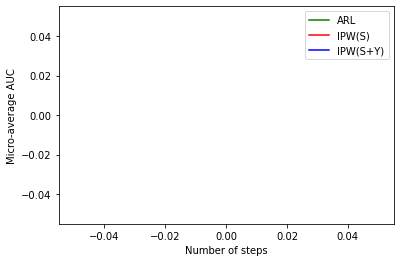

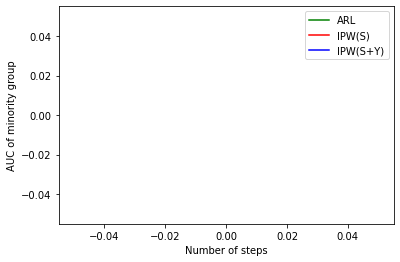

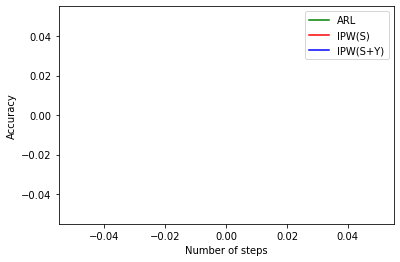

In [34]:
plot_args.models = ['ARL', 'IPW(S)', 'IPW(S+Y)']
for metric in metrics:
    plot_args.metric = metric
    plot.main(plot_args)
    plt.show()

## Computational identifiability with a linear adversary
A fundamental assumption justifying ARL is that the adversary is able to at least partially determine the protected group memberships from the available features. As in the paper, we test this by training a classifier with the same architecture we use for the adversary to classify samples according to the protected features.

For this section, we don't provide precomputed results you can load because training the models should be very quick.

In [35]:
ident_args = Namespace(
    optimizer='Adagrad',
    seed=0,
    learning_rate=0.001,
    batch_size=256,
    train_steps=5000,
    num_workers=4,
    disable_warnings=True,
    tf_mode=True,
    suffix='',
    p_bar=False
)

In [36]:
datasets = ['Adult', 'LSAC', 'COMPAS']
targets = ['race', 'sex']
accuracies = defaultdict(dict)

for dataset, target in itertools.product(datasets, targets):
    ident_args.dataset = dataset
    ident_args.target_grp = target
    ident_args.dataset_type = 'image' if ident_args.dataset in ['EMNIST'] else 'tabular'

    accuracies[target][dataset] = identifiability.main(ident_args)[0]['test/accuracy']

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Linear            | 103   
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
103       Trainable params
0         Non-trainable params
103       Total params
/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Con

time to fit was 29.12799620628357


/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.9028), 'test/loss': tensor(0.3863)}
--------------------------------------------------------------------------------


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Linear            | 103   
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
103       Trainable params
0         Non-trainable params
103       Total params


time to fit was 32.99863028526306
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.6883), 'test/loss': tensor(0.5832)}
--------------------------------------------------------------------------------


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Linear            | 12    
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params


time to fit was 22.45482325553894
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.6827), 'test/loss': tensor(0.5940)}
--------------------------------------------------------------------------------


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Linear            | 12    
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params


time to fit was 10.747794389724731
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.5448), 'test/loss': tensor(0.7852)}
--------------------------------------------------------------------------------


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Linear            | 449   
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
449       Trainable params
0         Non-trainable params
449       Total params


time to fit was 5.623831033706665
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.5612), 'test/loss': tensor(0.6829)}
--------------------------------------------------------------------------------


GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type              | Params
-----------------------------------------------
0 | net      | Linear            | 449   
1 | loss_fct | BCEWithLogitsLoss | 0     
-----------------------------------------------
449       Trainable params
0         Non-trainable params
449       Total params


time to fit was 9.346364974975586
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/accuracy': tensor(0.7839), 'test/loss': tensor(0.6163)}
--------------------------------------------------------------------------------


In [37]:
bold_dict = defaultdict(lambda: defaultdict(bool))

table = create_table(accuracies, datasets, bold_dict, create_markdown_line_scalar)
display(Markdown(IDENTIFIABILITY_HEADER + table))


|Target|Adult|LSAC|COMPAS|
|---|---|---|---|
| race | 0.90 | 0.68 | 0.56 |
| sex | 0.69 | 0.54 | 0.78 |


## Adversary outputs
As a final experiment, we plot the distribution of the weights $\lambda_i$ that the adversary assigns to samples. By default, ARL is trained on the Adult dataset with the optimal hyperparameters as determined by our grid search. Then the weights are calculated on the test set and for each of TP, FP, TN and FN, a kernel density estimation is performed to get a plot of the distribution. We use Gaussian kernels with a bandwith of 0.3.

The hyperparameters can be adjusted with the usual `args` object. In particular, you can change the dataset that way.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | learner   | Learner           | 8.6 K 
1 | adversary | Adversary         | 103   
2 | loss_fct  | BCEWithLogitsLoss | 0     
------------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params


creating dir ./training_logs/Adult/ARL_example_weights/version_1611828298


/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/erik/.miniconda3/envs/fact-ai/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: training_step returned None if it was on purpose, ignore this warning...
  warnings.warn(*args, **kwargs)


time to fit was 11.819230318069458
AUC Results = {'min_auc': 0.884856641292572, 'macro_avg_auc': 0.9175562709569931, 'micro_avg_auc': 0.909850537776947, 'minority_auc': 0.9365413784980774, 'accuracy': 0.8396289944648743}
Evaluating adversary scores on test set


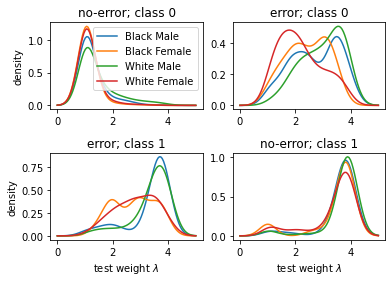

In [4]:
arl_args = Namespace(**vars(default_args))
arl_args.dataset = 'Adult'
arl_args.batch_size = 128
arl_args.prim_lr = 0.1

# There's no reason to change the following settings unless you know what you're doing.
# Many of them don't have an effect in this setting anyway.
arl_args.notebook = True
arl_args.model = 'ARL'
arl_args.dataset_type = 'tabular'

adversary_outputs.main(arl_args)

## Notes on further results


### Grid search
Our `main.py` script can run the entire grid search that we used to determine learning rate and batch size. Simply run `python main.py --model MODEL --dataset DATASET --tf_mode --disable_warnings`. You may also want to set `--num_cpus` and `--num_workers`. Do this for all the models and datasets you want to check. The optimal hyperparameters will be printed and also saved to disk. Then you can enter those in the `optimal_hparams` dictionary above and continue in the section "Runs for all models and datasets" to do several different runs with those hyperparameters and average the results.

### Comparison to Tensorflow implementation (Appendix A)
For our report, we also compared the results we got using our PyTorch implementation to the ones we got when using the authors' Tensorflow implementation (both using the same hyperparameters). Because this requires setting up and running the code published by the authors in addition to the code contained in this repository, we do not include this experiment in this notebook.

To reproduce it, the comparison between our results and those from the paper we did above can be used as a basis. Instead of loading the `their_results` variable from the JSON file with the paper results, you will need to run the authors' implementation (with the same hyperparameters used for `our_results`) and load the results you get this way.

### Runs with 100k steps (Appendix C)
To use 100k steps instead of the default 5k, simply change `args.train_steps` before running the cell that trains all models on all datasets.